# Churn Prediction with PySpark


The different classifiers used are:
* Logistic regression
* Naive Bayes
* Linear Support Vector Machine
* Decision tree classifier




> Add blockquote


## Initializing a Spark session

In [ ]:

# Downloading pyspark library
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2695add862629411f31515fd3b7ab2feb2e84196dffe1b75213ef7c2c53c1ea6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing and configuration of Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()


##  Fetching and Importing Churn Data


In [ ]:
import os
csv_path = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/archive (1)'):
    for filename in filenames:
        csv_path.append(os.path.join(dirname, filename))
print(csv_path)

['/content/drive/MyDrive/Colab Notebooks/archive (1)/churn-bigml-20.csv', '/content/drive/MyDrive/Colab Notebooks/archive (1)/churn-bigml-80.csv']


In [ ]:
CV_data = spark.read.csv(csv_path[1], header='true', inferSchema='true')

final_test_data = spark.read.csv(csv_path[0], header='true', inferSchema='true')

CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [ ]:
CV_data.select("*").toPandas().head().transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3



##  Summary Statistics


In [ ]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

CV_data.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64
Total eve minutes,2666,200.38615903976006,50.95151511764598,0.0,363.7
Total eve calls,2666,100.02363090772693,20.16144511531889,0,170
Total eve charge,2666,17.033072018004518,4.330864176799864,0.0,30.91



##  Correlations and Data Preparation


In [ ]:
sampled_data = CV_data.select(numeric_features).sample(False, 0.10)


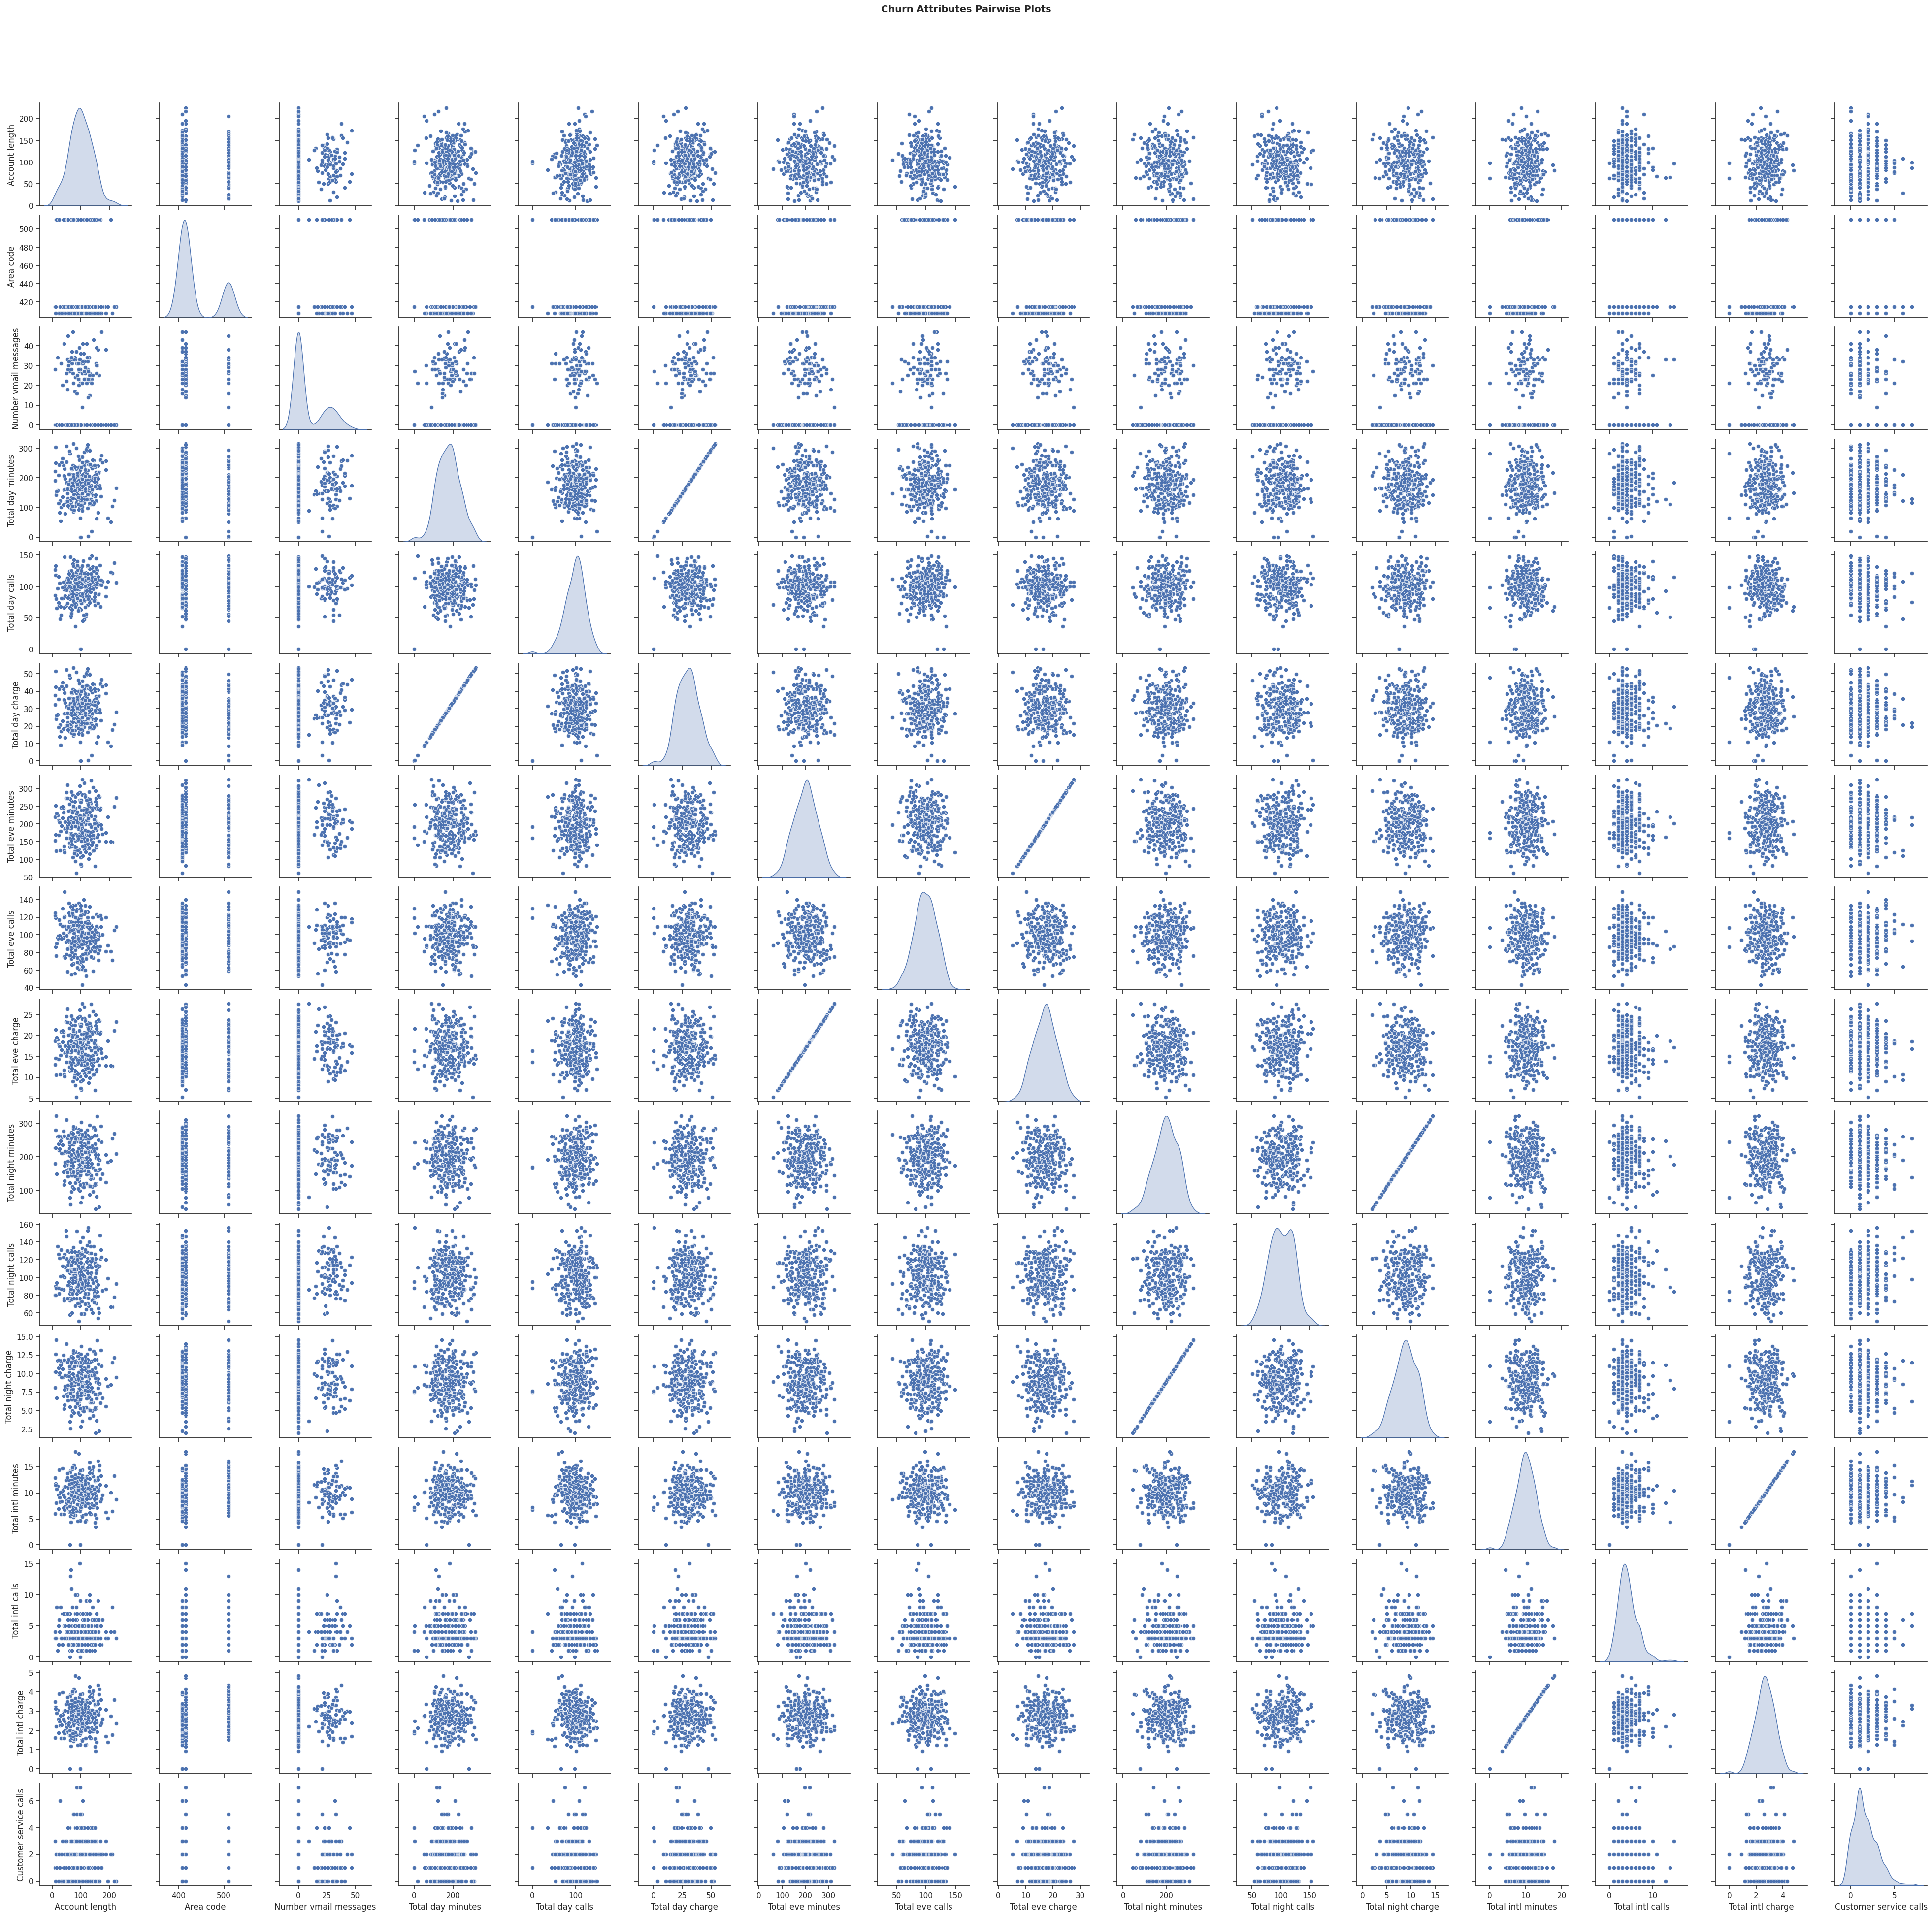

In [ ]:
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Churn Attributes Pairwise Plots', fontsize=14, fontweight='bold');

In [ ]:
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df

In [ ]:
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

CV_data = get_data(CV_data, removeCols=removeCols)
final_test_data = get_data(final_test_data, removeCols=removeCols)

Let's take a  look at the resulting datasets.

In [ ]:
import pandas as pd
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()

,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0



## Using Spark MLlib Package
###  Decision Tree Models
###  Model Training

In [ ]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(0.0, [128.0,0.0,1.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]), LabeledPoint(0.0, [107.0,0.0,1.0,26.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0])]
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 12 <= 3.5)
   If (feature 4 <= 261.85)
    Predict: 0.0
   Else (feature 4 > 261.85)
    Predict: 1.0
  Else (feature 12 > 3.5)
   If (feature 4 <= 171.45)
    Predict: 1.0
   Else (feature 4 > 171.45)
    Predict: 0.0



In [ ]:
print("Feature 12 is the {}.".format(CV_data.columns[12]))
print("Feature 4 is the {}.".format(CV_data.columns[4]))

Feature 12 is the Customer service calls.
Feature 4 is the Total day minutes.



### Model Evaluation


In [ ]:
def printAllMetrics(predictionsDF):
    TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
    FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
    TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
    FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

    precision_p   = TP/(TP+FP)
    precision_n   = TN/(TN+FN)
    recall_p      = TP/(TP+FN)
    recall_n      = TN/(TN+FP)
    f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
    f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
    avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
    avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
    avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
    accuracy      = (TN+TP)/(TP+FN+TN+FP)

    print('Precision of True    ', precision_p)
    print('Precision of False   ', precision_n)
    print('** Avg Precision     ', avg_precision)
    print('Recall of True       ', recall_p)
    print('Recall of False      ', recall_n)
    print('** Avg Recall        ', avg_recall)
    print('F1 of True           ', f1_p)
    print('F1 of False          ', f1_n)
    print('** Avg F1            ', avg_f1)
    print('** Accuracy          ', accuracy)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall)
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix
 [[423.  26.]
 [ 46.  30.]]
Precision of True     0.5357142857142857
Precision of False    0.9019189765458422
Weighted Precision    0.8489064879683217
Recall of True        0.39473684210526316
Recall of False       0.9420935412026726
Weighted Recall       0.8628571428571429
FMeasure of True      0.45454545454545453
FMeasure of False     0.9215686274509803
Weighted fMeasure     0.853961463373228
Accuracy              0.8628571428571429


In [ ]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   29|
|  0.0|           1.0|   27|
|  1.0|           0.0|   50|
|  0.0|           0.0|  419|
+-----+--------------+-----+

Precision of True     0.5357142857142857
Precision of False    0.9057815845824411
** Avg Precision      0.8534202459280558
Recall of True        0.40540540540540543
Recall of False       0.9420935412026726
** Avg Recall         0.8661567877629063
F1 of True            0.46153846153846156
F1 of False           0.923580786026201
** Avg F1             0.8582057726187579
** Accuracy           0.8661567877629063


In [ ]:
CV_data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0| 2278|
|  1.0|  388|
+-----+-----+




###  Stratified Sampling


In [ ]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: CV_data.select("Churn").where('Churn == 1').count()/
                                                          CV_data.select("Churn").where('Churn == 0').count(), 1: 1.0}, seed = 5323)

stratified_CV_data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0|  388|
|  1.0|  388|
+-----+-----+



Let's build a new model using the evenly distributed data set and see how it performs.

In [ ]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

print("========================================")

predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

Confusion Matrix
 [[65. 10.]
 [29. 52.]]
Precision of True     0.8387096774193549
Precision of False    0.6914893617021277
Weighted Precision    0.7679306794783802
Recall of True        0.6419753086419753
Recall of False       0.8666666666666667
Weighted Recall       0.75
FMeasure of True      0.7272727272727273
FMeasure of False     0.7692307692307693
Weighted fMeasure     0.7474448628294783
Accuracy              0.75
Precision of True     0.8387096774193549
Precision of False    0.5701754385964912
** Avg Precision      0.724277473375521
Recall of True        0.5148514851485149
Recall of False       0.8666666666666667
** Avg Recall         0.6647727272727273
F1 of True            0.6380368098159509
F1 of False           0.6878306878306878
** Avg F1             0.6592557919245036
** Accuracy           0.6647727272727273


With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.


##  Using Spark ML Package
###  Pipelining
### Model Selection


In [ ]:
stratified_CV_data.show(2)

+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|Account length|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total eve minutes|Total eve calls|Total night minutes|Total night calls|Total intl minutes|Total intl calls|Customer service calls|Churn|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|           118|               1.0|            0.0|                    0|            223.4|             98|            220.6|            101|              203.9|              118|               6.3|               6|                     0|  0.0|
|            73|    

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')

    # Automatically identify categorical features and index them
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

    pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

    model = pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(labelCol))

    return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

In [ ]:
numericCols = stratified_CV_data.columns
numericCols.remove("Churn")

vectorized_CV_data = get_dummy(CV_data, numericCols, "Churn")
vectorized_stratified_CV_data = get_dummy(stratified_CV_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(final_test_data, numericCols, "Churn")

In [ ]:
vectorized_stratified_CV_data.show(2, False)

+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|features                                                          |label|indexedFeatures                                                   |indexedLabel|
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|[118.0,1.0,0.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]|0.0  |[118.0,1.0,0.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]|0.0         |
|[73.0,0.0,0.0,0.0,224.4,90.0,159.5,88.0,192.8,74.0,13.0,2.0,1.0]  |0.0  |[73.0,0.0,0.0,0.0,224.4,90.0,159.5,88.0,192.8,74.0,13.0,2.0,1.0]  |0.0         |
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
only showing top 2 rows




###  validation


In [ ]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
    names = []
    f1_train = []
    f1_test = []
    wp_train = []
    wp_test = []
    wr_train = []
    wr_test = []
    acc_train = []
    acc_test = []

    evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")

    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
    evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

    for name, clf in classifiers:
        cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
        cvModel = cv.fit(vectorized_train_data)
        predict_train = cvModel.transform(vectorized_train_data)
        predict_test = cvModel.transform(vectorized_test_data)
        f1_train.append(evaluatoracc.evaluate(predict_train))
        f1_test.append(evaluatoracc.evaluate(predict_test))
        wp_train.append(evaluatorwp.evaluate(predict_train))
        wp_test.append(evaluatorwp.evaluate(predict_test))
        wr_train.append(evaluatorwr.evaluate(predict_train))
        wr_test.append(evaluatorwr.evaluate(predict_test))
        acc_train.append(evaluatoracc.evaluate(predict_train))
        acc_test.append(evaluatoracc.evaluate(predict_test))
        names.append(name)

    cvResults = spark.createDataFrame(zip(names, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test),
                                       schema=['Classifier name', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])

    for t in cvResults.dtypes:
        if t[1] == 'double':
            cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))

    return cvResults

In [ ]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


cvResults_CV_data = cvComparing(vectorized_train_data=vectorized_CV_data, vectorized_test_data=vectorized_final_test_data,
                                classifiers=classifiers, paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data=vectorized_stratified_CV_data,
                                           vectorized_test_data=vectorized_final_test_data, classifiers=classifiers,
                                           paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)


###  Model Evaluation


In [ ]:
cvResults_CV_data.toPandas().set_index('Classifier name')

,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,
LR,0.863,0.855,0.863,0.855,0.835,0.820,0.863,0.855
NB,0.632,0.625,0.632,0.625,0.800,0.804,0.632,0.625
SVC,0.854,0.858,0.854,0.858,0.730,0.735,0.854,0.858
DT,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

#clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_CV_data)
pred_train = clfModel.transform(vectorized_stratified_CV_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.6033201874136246
Weighted Recall       0.6018041237113402
F1                    0.6003380185910225
Accuracy              0.6018041237113402
Precision of True     0.5908045977011495
Precision of False    0.6158357771260997
** Avg Precision      0.6033201874136246
Recall of True        0.6623711340206185
Recall of False       0.5412371134020618
** Avg Recall         0.6018041237113402
F1 of True            0.6245443499392467
F1 of False           0.5761316872427983
** Avg F1             0.6003380185910225
** Accuracy           0.6018041237113402



## Conclusion

The Decision tree and Random forest are the more efficient classifiers. However, the best model created according to the cross validation process seems to be the Decision tree. Indeed, the different metrics obtained by using this classifier are higher as well as very close to each other comparing to those of the other classifiers.